**Title: Linear Kalman Filter for 2D motion**<br><br>
**Description:** This code implements a linear Kalman filter for a 2D object moving with constant velocity. In this implementation, the state of the object is represented by a 4D vector, containing the position and velocity in both the x and y directions. The Kalman filter predicts the next state of the object based on the previous state and a state transition model, and updates the state estimate based on noisy measurements of the object's position. The Kalman filter uses a covariance matrix to model the uncertainty in the state estimate, and iteratively updates this matrix based on the prediction and measurement steps.<br><br>
**Author:** Akshay Laxman Powar<br>
**Date:** 20.02.2023<br>

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt


# offsets of each variable in the mean state matrix
num_states = 4
measu_inputs = 2
state_Dx, state_Dy, state_Vx, state_Vy = 0,1,2,3
class KF:
    """
    Implementation of the Linear Kalman filter.
    """
    def __init__(self, initial_x, 
                       initial_v,
                       accel_variance) -> None:
        
        """
        Initializes the mean state and covariance matrix of the state Gaussian random variable (GRV).
        
        Args:
            initial_x (list): The initial position of the system as a list of [x, y] coordinates.
            initial_v (list): The initial velocity of the system as a list of [vx, vy] coordinates.
            accel_variance (float): The variance of the acceleration noise.
        """
        
        # mean state matrix of Gaussian Random Variable (GRV)
        # initialized as 4x1 matrix
        self._x = np.zeros(num_states).reshape(num_states,1) 
        self._x[state_Dx] = initial_x[0]
        self._x[state_Dy] = initial_x[1]
        self._x[state_Vx] = initial_v[0]
        self._x[state_Vy] = initial_v[1]
        
        # noise input matrix
        # initialized as 2x2 matrix
        self._accel_variance = np.array([[accel_variance,0],[0,accel_variance]]) 

        # covariance of state Gaussian Random Variable (GRV)
        # initialized as # 4x4 identity matrix
        self._P = np.eye(num_states)  
        

    def predict(self, dt: float) -> None:
        """
        Predict the state of the object after a time interval of dt seconds.
        
        Parameters
        ----------
        dt : float
            The time interval in seconds.
            
        Returns
        -------
        None
        
        
        Equations related to prediction Step
        x = F x
        P = F P Ft + G a Gt
        """
        
        # 4x4 state transition matrix
        F = np.eye(num_states) 
        F[state_Dx,state_Vx] = dt     
        F[state_Dy,state_Vy] = dt
        '''
        F = array([[1., 0., 1., 0.],
                   [0., 1., 0., 1.],
                   [0., 0., 1., 0.],
                   [0., 0., 0., 1.]])
        '''
        # 4x1 mean state matrix at time t
        # x = F x --> new state as per the state transition matrix
        predicted_x = F.dot(self._x)
        
        # 4x2 control matrix
        G = np.zeros((4,2)) 
        G[state_Dx,state_Dx] =G[state_Dy,state_Dy] = dt**2/2
        G[state_Vx,state_Dx]= G[state_Vy,state_Dy] = dt

        # 4x4 state covariance matrix at time t
        predicted_P = F.dot(self._P).dot(F.T) + G.dot(self._accel_variance).dot(G.T)

        self._P = predicted_P
        self._x = predicted_x

    def update(self, meas_value, meas_variance):
        """
        Update the state of the object after a time interval of dt seconds when measurements are received.
        
        Parameters
        ----------
        meas_value : array
            The actual measurement at a given time.
        meas_variance : array 
            The covariance matrix of the measurement noise.
        
        Returns
        -------
        None
        
        Equations related to update Step
        y = z - H x
        S = H P Ht + R
        K = P Ht S^-1
        x = x + K y
        P = (I - K H) * P
        """
        
        # 2x4 state observation matrix 
        H = np.concatenate((np.eye(2),np.zeros((2,2))),axis=1)

        # 2x1 measurement matrix at time t ([[mDx],[mDy]])
        z = meas_value 
        
        # 2x2 measurement noise covariance matrix ([[sigma_x^2, 0], [0, sigma_y^2]])
        R = meas_variance

        # 4x1 innovation i.e (difference between the actual measurement z and the predicted measurement Hx)
        y = z - H.dot(self._x)
        
        # 2x2 innovation covariance matrix (a measure of the error between the predicted measurement and the actual measurement)
        S = H.dot(self._P).dot(H.T) + R
        
        # 4x1 Kalman Gain Matrix 
        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        # 4x1 updated state matrix after measurement at time t
        updated_x = self._x + K.dot(y)
        
        # 4x4 updated state covariance matrix after measurement at time t
        updated_P = (np.eye(4) - K.dot(H)).dot(self._P)

        self._x = updated_x
        self._P = updated_P
        

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

    @property
    def pos(self) -> float:
        return self._x[iX]

    @property
    def vel(self) -> float:
        return self._x[iV]

In [5]:
def kalman_filter_localization(measurement_rate:int):
    
    plt.ion()
    plt.figure(figsize=(15,9))

    # defining the initial true mean state of a system at time t=0
    true_mean_state_vehicle_center = np.array([[20],[50]])
    true_mean_state_gps1 = np.array([[-1],[0]]) + true_mean_state_vehicle_center
    true_mean_state_gps2 = np.array([[+0.5],[0.8660]]) + true_mean_state_vehicle_center
    true_mean_state_gps3 = np.array([[0.5],[-0.8660]]) + true_mean_state_vehicle_center

    # sensor measurement variance
    sigma_measurement = 0.2
    # sensor measurement variance matrix 
    measurement_variance = np.array([[sigma_measurement,0],[0,sigma_measurement]])

    # Velocity matrix used for creating a path based on initial true mean state
    input_velocity = np.array([[2],[1]])


    # initialize the class KF with constructor parameters
    kalman_filter_1 = KF(initial_x=np.array([[11.5],[50.5]]), 
            initial_v=np.array([[1.98],[1.02]]), 
            accel_variance=0.5)

    # minimum time step (dt) used in the simulation
    time_steps = 1
    # total number of time steps for which simulation will run
    total_time_steps = 1000
    # time step at which measurement is received

    # time step at which measurement update is done
    measurement_time_steps = []


    mean_state_estimate_1 = []  #property of kalman_filter class
    mean_state_estimate_error_1 = [] #property of kalman_filter class

    true_mean_state_over_total_time_steps_vehicle_center = []
    true_mean_state_over_total_time_steps_gps1 = []
    true_mean_state_over_total_time_steps_gps2 = []
    true_mean_state_over_total_time_steps_gps3 = []
    input_velocity_over_total_time_steps = []

    mean_state_after_prediction = []
    mean_state_after_gps1_update = []
    mean_state_after_gps2_update = []
    mean_state_after_gps3_update = []

    for step in range(total_time_steps):

        if step>500 and step<600:
            input_velocity = (np.array([[0.98,0],[0,1]])).dot(input_velocity)
        if step>650 and step<700:
            input_velocity = (np.array([[1,0],[0,1.03]])).dot(input_velocity)

        mean_state_estimate_1.append(kalman_filter_1.mean)      
        mean_state_estimate_error_1.append(kalman_filter_1.cov)


        '''
        True mean position of the vehicle after minimum simulation time step. To calculate this 
        input velocity times the minimum time step is added to the previous true mean state.
        ---------------
        new position = old position + input velocity * simulation time step
        this is equivalent to 
        i = i + 2
        ---------------
        To simulate real-world conditions, random Gaussian noise is added to this position 
        to generate artificial position. This generated position is treated as sensor measurements.
        '''
        true_mean_state_vehicle_center = true_mean_state_vehicle_center + time_steps * input_velocity
        true_mean_state_gps1 = true_mean_state_gps1 + time_steps * input_velocity
        true_mean_state_gps2 = true_mean_state_gps2 + time_steps * input_velocity
        true_mean_state_gps3 = true_mean_state_gps3 + time_steps * input_velocity

        kalman_filter_1.predict(dt=time_steps)
        mean_state_after_prediction.append(kalman_filter_1.mean)

        if step != 0 and step % measurement_rate == 0:
            ''' Update by adding the random Gaussian noise into the true mean position'''
            measurement_time_steps.append(step)


            kalman_filter_1.update(meas_value=((true_mean_state_gps1 + np.random.randn() * np.sqrt(sigma_measurement))-np.array([[-1],[0]])),
                      meas_variance=measurement_variance)
            mean_state_after_gps1_update.append(kalman_filter_1.mean)


            kalman_filter_1.update(meas_value=((true_mean_state_gps2 + np.random.randn() * np.sqrt(sigma_measurement))-np.array([[+0.5],[0.8660]])),
                       meas_variance=measurement_variance)
            mean_state_after_gps2_update.append(kalman_filter_1.mean)


            kalman_filter_1.update(meas_value=(true_mean_state_gps3 + np.random.randn() * np.sqrt(sigma_measurement)-np.array([[0.5],[-0.8660]])),
                       meas_variance=measurement_variance)
            mean_state_after_gps3_update.append(kalman_filter_1.mean)

        # Appending the variable value into list which store data for entire time horizon
        true_mean_state_over_total_time_steps_vehicle_center.append(true_mean_state_vehicle_center)
        true_mean_state_over_total_time_steps_gps1.append(true_mean_state_gps1)
        true_mean_state_over_total_time_steps_gps2.append(true_mean_state_gps2)
        true_mean_state_over_total_time_steps_gps3.append(true_mean_state_gps3)
        input_velocity_over_total_time_steps.append(input_velocity)

    # since the data stored in the variable in a list format we have to convert it into array for easy plotting
    true_mean_state_over_total_time_steps_vehicle_center = np.array(true_mean_state_over_total_time_steps_vehicle_center)
    true_mean_state_over_total_time_steps_gps1 = np.array(true_mean_state_over_total_time_steps_gps1)
    true_mean_state_over_total_time_steps_gps2 = np.array(true_mean_state_over_total_time_steps_gps2)
    true_mean_state_over_total_time_steps_gps3 = np.array(true_mean_state_over_total_time_steps_gps3)
    input_velocity_over_total_time_steps = np.array(input_velocity_over_total_time_steps)

    plt.subplot(2, 2, 1)
    plt.title('PositionXGPS')
    plt.plot([ms[0] for ms in mean_state_estimate_1], 'r') # ms[0] has x position estimates
    plt.plot(true_mean_state_over_total_time_steps_gps1[:,0], 'm') 
    plt.plot(true_mean_state_over_total_time_steps_gps2[:,0], 'y')
    plt.plot(true_mean_state_over_total_time_steps_gps3[:,0], 'c')
    #plt.plot([mu[0] - 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
    #plt.plot([mu[0] + 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate

    plt.subplot(2, 2, 2)
    plt.title('VelocityX')
    plt.plot(input_velocity_over_total_time_steps[:,0], 'k')
    plt.plot([ms[2] for ms in mean_state_estimate_1], 'r')  # ms[2] has x velocity estimates
    #plt.plot([mu[2] - 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
    #plt.plot([mu[2] + 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate

    plt.subplot(2, 2, 3)
    plt.title('PositionYGPS')
    plt.plot([ms[1] for ms in mean_state_estimate_1], 'r') # ms[1] has x position estimates
    plt.plot(true_mean_state_over_total_time_steps_gps1[:,1], 'm')
    plt.plot(true_mean_state_over_total_time_steps_gps2[:,1], 'y')
    plt.plot(true_mean_state_over_total_time_steps_gps3[:,1], 'c')
    #plt.plot([mu[1] - 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
    #plt.plot([mu[1] + 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate

    plt.subplot(2, 2, 4)
    plt.title('VelocityY')
    plt.plot(input_velocity_over_total_time_steps[:,1], 'k')
    plt.plot([ms[3] for ms in mean_state_estimate_1], 'r') # ms[3] has y velocity estimates
    #plt.plot([mu[3] - 2*np.sqrt(cov[3,3]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
    #plt.plot([mu[3] + 2*np.sqrt(cov[3,3]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate
    
    
    mse_pred = np.square(
                    np.subtract(np.array(true_mean_state_over_total_time_steps_vehicle_center[:, 0, 0]), 
                                np.array(mean_state_after_prediction)[:, 0, 0])
                    ).mean()

    rmse_pred = np.sqrt(mse_pred)
    
    mse_est_using_gps1 = np.square(
                                np.subtract(np.array(true_mean_state_over_total_time_steps_vehicle_center[measurement_time_steps, 0, 0]), 
                                            np.array(mean_state_after_gps1_update)[:, 0, 0])
                                ).mean()
    rmse_est_using_gps1 = np.sqrt(mse_est_using_gps1)
    
    mse_est_using_gps2 = np.square(
                                np.subtract(
                                    np.array(true_mean_state_over_total_time_steps_vehicle_center[measurement_time_steps, 0, 0]), 
                                    np.array(mean_state_after_gps2_update)[:, 0, 0])
                                ).mean()
    rmse_est_using_gps2 = np.sqrt(mse_est_using_gps2)
    
    mse_est_using_gps3 = np.square(
                                np.subtract(np.array(true_mean_state_over_total_time_steps_vehicle_center[measurement_time_steps, 0, 0]), 
                                            np.array(mean_state_after_gps3_update)[:, 0, 0])
                                ).mean()
    rmse_est_using_gps3 = np.sqrt(mse_est_using_gps3)
    
    mse = np.square(
                np.subtract(np.array(true_mean_state_over_total_time_steps_vehicle_center[:, 0, 0]), 
                            np.array(mean_state_estimate_1)[:, 0, 0])
                ).mean()
    rmse = np.sqrt(mse)
    
    return np.array([rmse_pred, rmse_est_using_gps1, rmse_est_using_gps2, rmse_est_using_gps3, rmse])

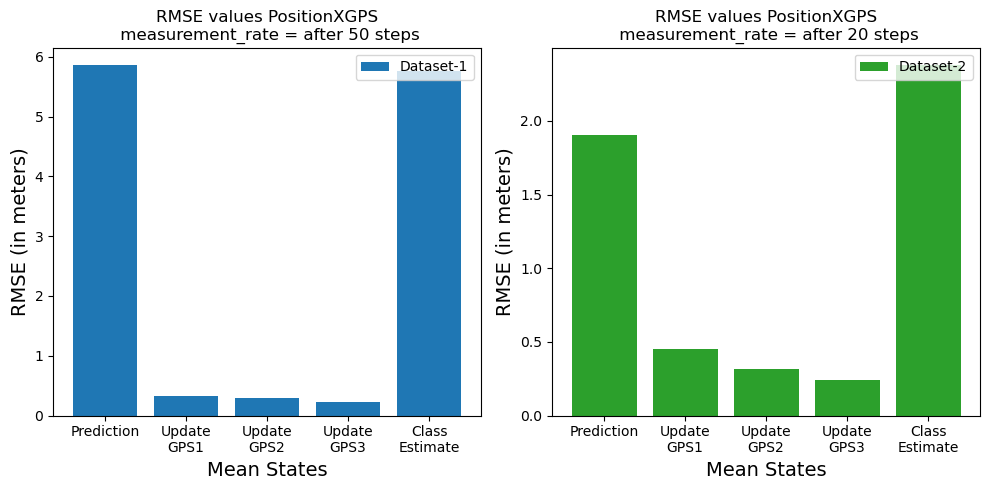

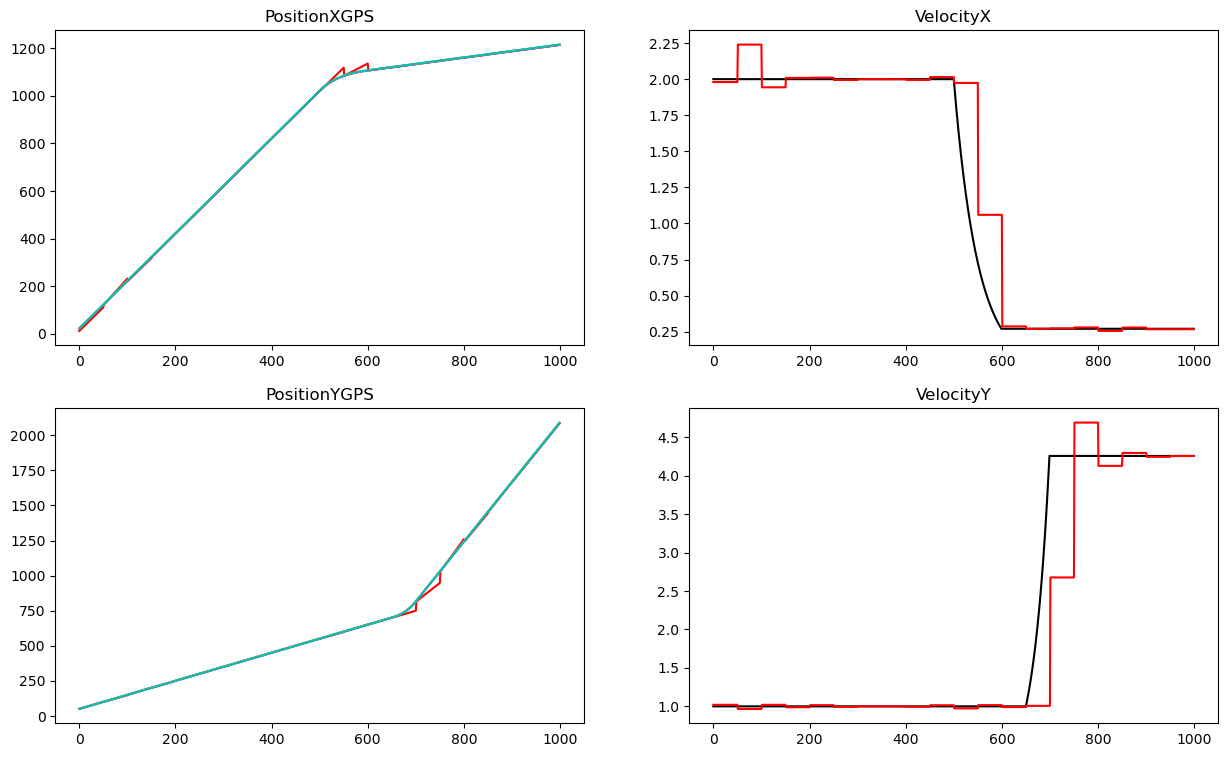

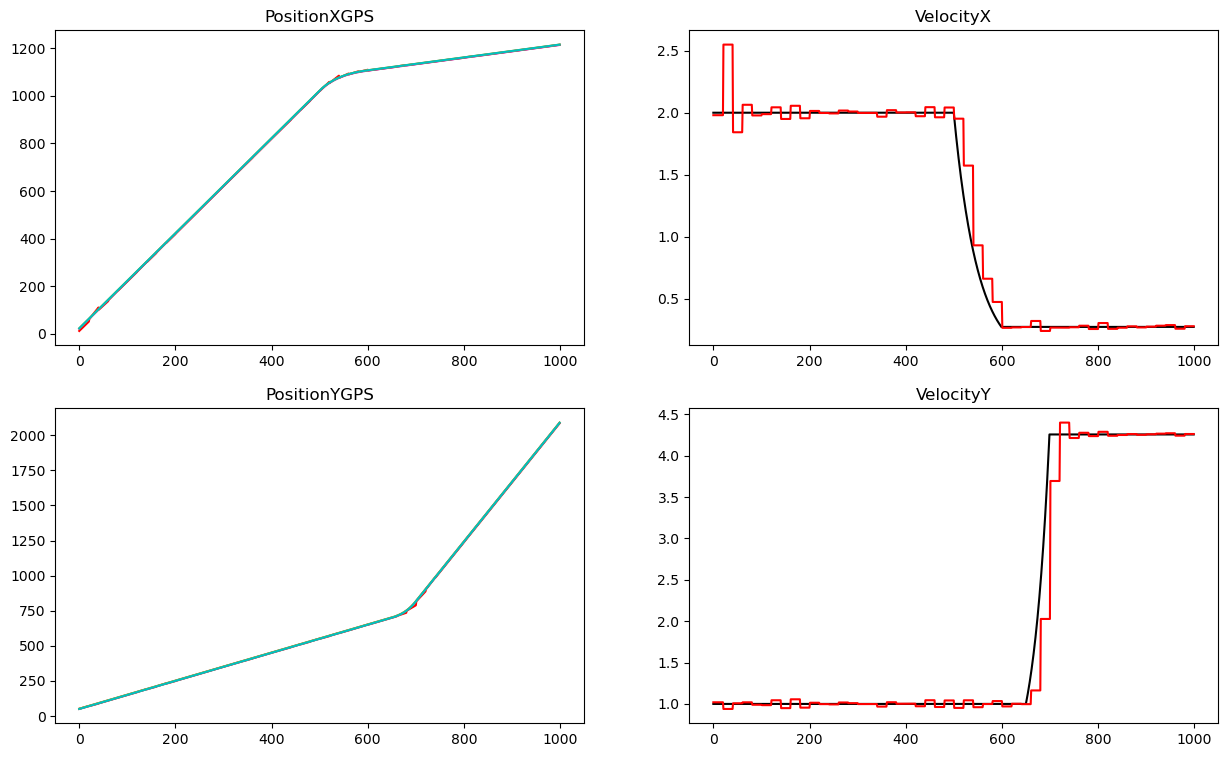

In [6]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a list of sensor names and RMSE values
labels = ['Prediction','Update\nGPS1', 'Update\nGPS2', 'Update\nGPS3', 'Class\nEstimate']
rmse_values_50 = kalman_filter_localization(50)
rmse_values_20 = kalman_filter_localization(20)

# Plot the RMSE values
ax1.bar(labels, rmse_values_50, capsize=5, color='tab:blue', label = 'Dataset-1')
ax1.set_title('RMSE values PositionXGPS\n measurement_rate = after 50 steps')
ax1.set_xlabel('Mean States', fontsize=14)
ax1.set_ylabel('RMSE (in meters)', fontsize=14)
ax1.legend(loc = 'upper right')

ax2.bar(labels, rmse_values_20, capsize=5, color='tab:green', label = 'Dataset-2')
ax2.set_title('RMSE values PositionXGPS\n measurement_rate = after 20 steps')
ax2.set_xlabel('Mean States', fontsize=14)
ax2.set_ylabel('RMSE (in meters)', fontsize=14)
ax2.legend(loc = 'upper right')

fig.tight_layout()
fig.savefig('bar_plot_rmse_50_20.png')
plt.show()